In [1]:
import pandas as pd
import numpy as np
import panel as pn
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import dash
from dash import dcc, html
import collections
from pptx import Presentation
import panel as pn
pn.extension
pn.extension('tabulator')
from datetime import date
import hvplot.pandas


In [2]:
df_hosp = pd.read_excel('HospitalDatabase.xlsx',sheet_name = None)
pats=df_hosp['Patients']
amb_visits=df_hosp['AmbulatoryVisits']
re_adm=df_hosp['ReAdmissionRegistry']
discharges=df_hosp['Discharges']
providers=df_hosp['Providers']
ed_unique=df_hosp['EDUnique']
ed_visits = df_hosp['EDVisits']

# 1.Create a dashboard with interactive pipeline based on provider speaclity

In [3]:
provider_deets = providers
provider_deets['YearsOfExperience'] = date.today().year - providers['ProviderDateOnStaff'].dt.year
provider_deets['DateOnStaff'] = providers['ProviderDateOnStaff'].dt.date
provider_deets = provider_deets[['ProviderID','ProviderName','ProviderSpecialty','YearsOfExperience','DateOnStaff']]
#provider_deets

In [4]:
idf = provider_deets.interactive()
pn.extension()

select_specialty = pn.widgets.Select(name='Provider Specialty', options=provider_deets['ProviderSpecialty'].unique().tolist(), width=150)

pn.Column(select_specialty)

Column
    [0] Select(name='Provider Specialty', options=['Pediatrics', ...], value='Pediatrics', width=150)

In [5]:
idf_provider = idf[(idf.ProviderSpecialty == select_specialty)]
provider_pipeline = idf_provider.pipe(pn.widgets.Tabulator, pagination='remote', page_size = 10, sizing_mode='stretch_width')

provider_pipeline


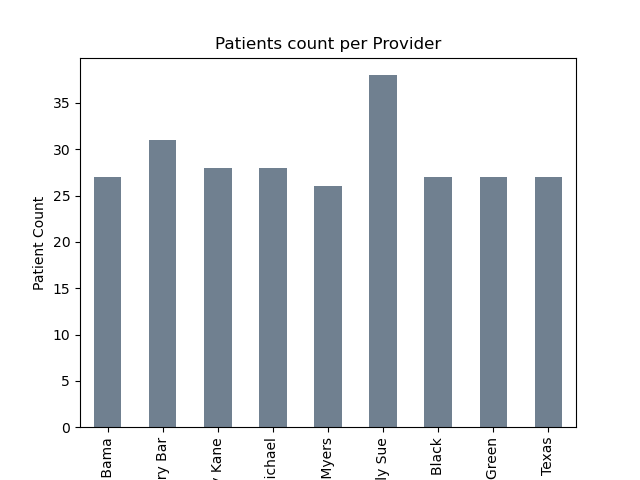

In [6]:
idf_amb_visits = amb_visits.interactive()
idf_provider = idf[(idf.ProviderSpecialty == select_specialty)]
patients_provider = idf_provider.merge(amb_visits, how='inner', on='ProviderID')
 
#matplotlib.rc('xtick', labelsize=7) 
#matplotlib.rc('ytick', labelsize=8)

provider_patient_count = patients_provider.groupby(['ProviderName']).size().plot(x=patients_provider['ProviderName'],kind='bar', color='slategray', 
    xlabel='Provider Name', ylabel='Patient Count', title='Patients count per Provider')

provider_patient_count

In [7]:
template = pn.template.FastListTemplate(
    title='<h1>Healthcare Provider Dashboard<h1>',
    sidebar=[#pn.Column(pn.pane.PNG('pngegg.png', height = 150), width=100),
         pn.pane.Markdown("##   Welcome to the Healthcare Provider Dashboard."
                         "Here, you can explore various healthcare providers' data based on their specialties."
                        "Use the sidebar to filter providers by specialty and see relevant information "),
        
            pn.pane.Markdown("## Select Provider Specialty"),select_specialty],
    main=[pn.Row(pn.Column(provider_pipeline.panel(width=1000))),
    pn.Row(pn.Row(provider_patient_count.panel(width=1000)))],
    background_color='#f0f0f0', accent_base_color="#87CEEB", header_background="#87CEEB"
)
template.show()

Launching server at http://localhost:50262


# 2. Create a Power BI quick visualization report view on Jupyter using the patients and Discharge dataset.





### To achieve this in your notebook, you need to install the required dependencies with 'pip install' and set up an authenticator code. Once you run the code, it will automatically display the Power BI report view with charts based on the dataset we used in our code. In the Power BI report view, you can manually select columns and change charts. The output is displayed below. I have attached screenshots for reference."

## These all are libraries  you need to install and run in your system to generate powerbi report view in juypter notebook

In [8]:
from powerbiclient import QuickVisualize, get_dataset_config, Report
from powerbiclient.authentication import DeviceCodeLoginAuthentication
from powerbiclient.authentication import InteractiveLoginAuthentication



## This is the local library to connect with powerbi

In [9]:
#pip install powerbiclient

### This command is to authenticate powebi client
### (we should run this after pip install to setup authenticator)

In [10]:
#DeviceCodeLoginAuthentication()(we should run this after pip install to setup authenticator)


### please follow the below steps to setup authentiactor

In [11]:
auth = InteractiveLoginAuthentication()

A local browser window will open for interactive sign in.

Interactive authentication successfully completed.
You are now logged in.

The result should be passed only to trusted code in your notebook.


In [16]:
df =pd.read_excel('HospitalDatabase.xlsx')

In [17]:
service_provided = pd.merge(pats,discharges,on = 'PatientID')

### This report view consists of countof patient by service, 
### count of Expected mortality by service,
### count of patient by primarydiagonisis 
### based on gender and race

In [19]:
PBI_visualize2 =PBI_visualize = QuickVisualize(get_dataset_config(service_provided), auth=auth)

PBI_visualize2

QuickVisualize()

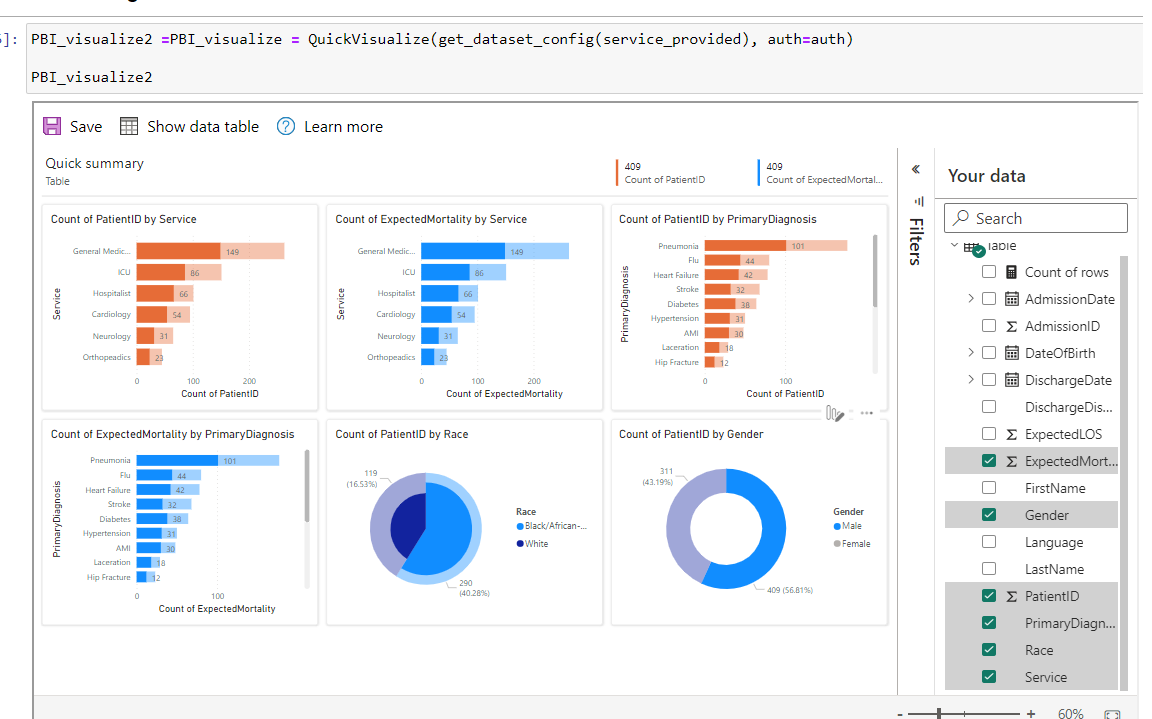

##  3.Create a Channel of Chart builders using ReAdmissionRegistry

## This PYWEDGE lib helps us to create multiple charts 


## It will enable us to create all the charts displayed below with just a two-line code. I have attached screenshots of a few charts for your reference. If you wish to display these charts in your notebook, you can do so by performing a 'pip install' and importing 'pywedge'. Afterward, you can click on the axes and generate the desired charts.







### To visualization panel follow the below steps 

In [20]:
#pip install pywedge

In [21]:
import pywedge as pw 

In [22]:
mc = pw.Pywedge_Charts(re_adm, c =None ,y ='PatientID')

C:\Users\lalas\anaconda3\lib\site-packages\pywedge\pywedge.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  self.X = self.train.drop(self.y,1)


In [23]:
Charts = mc.make_charts()
Charts

HTML(value='<h2>Pywedge Make_Charts </h2>')

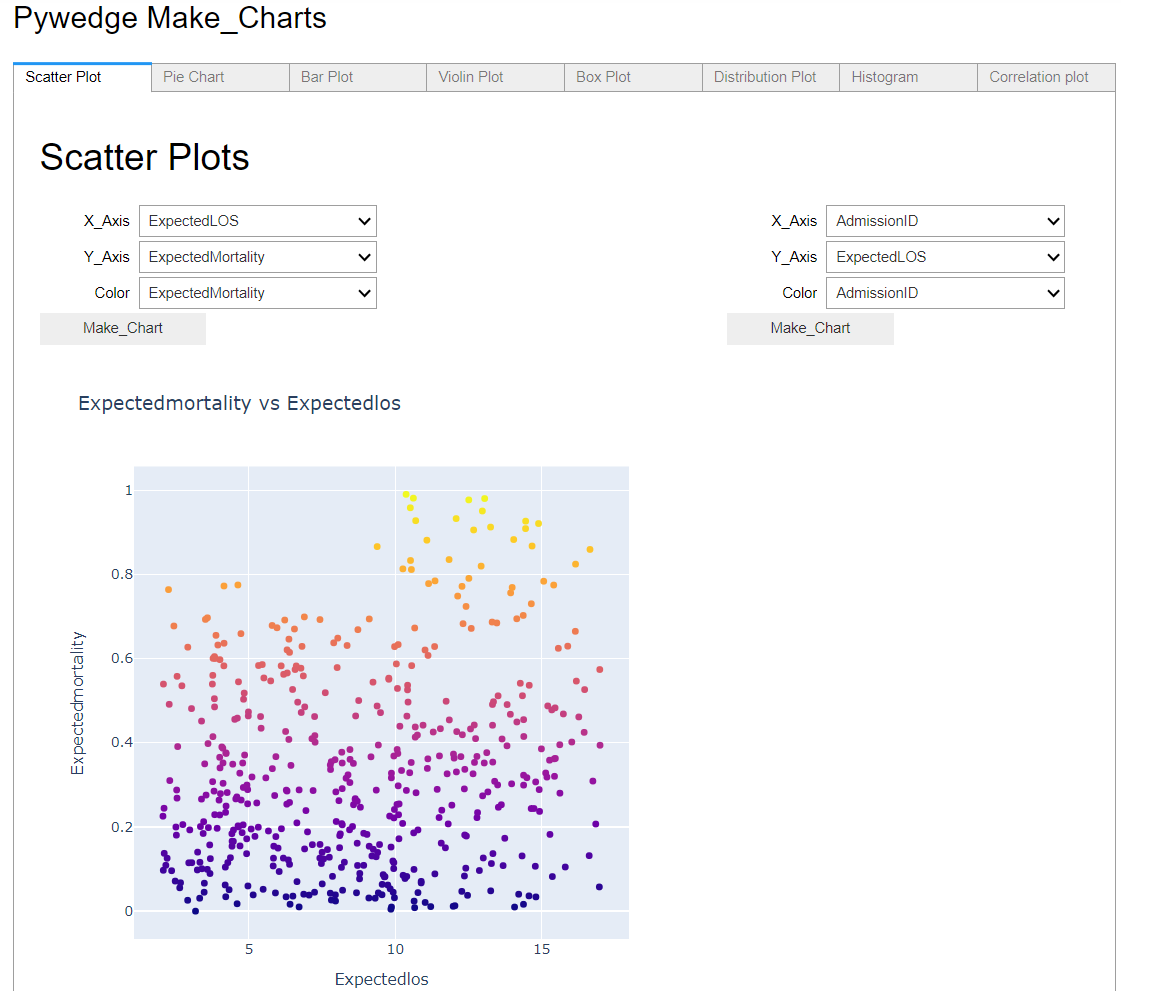

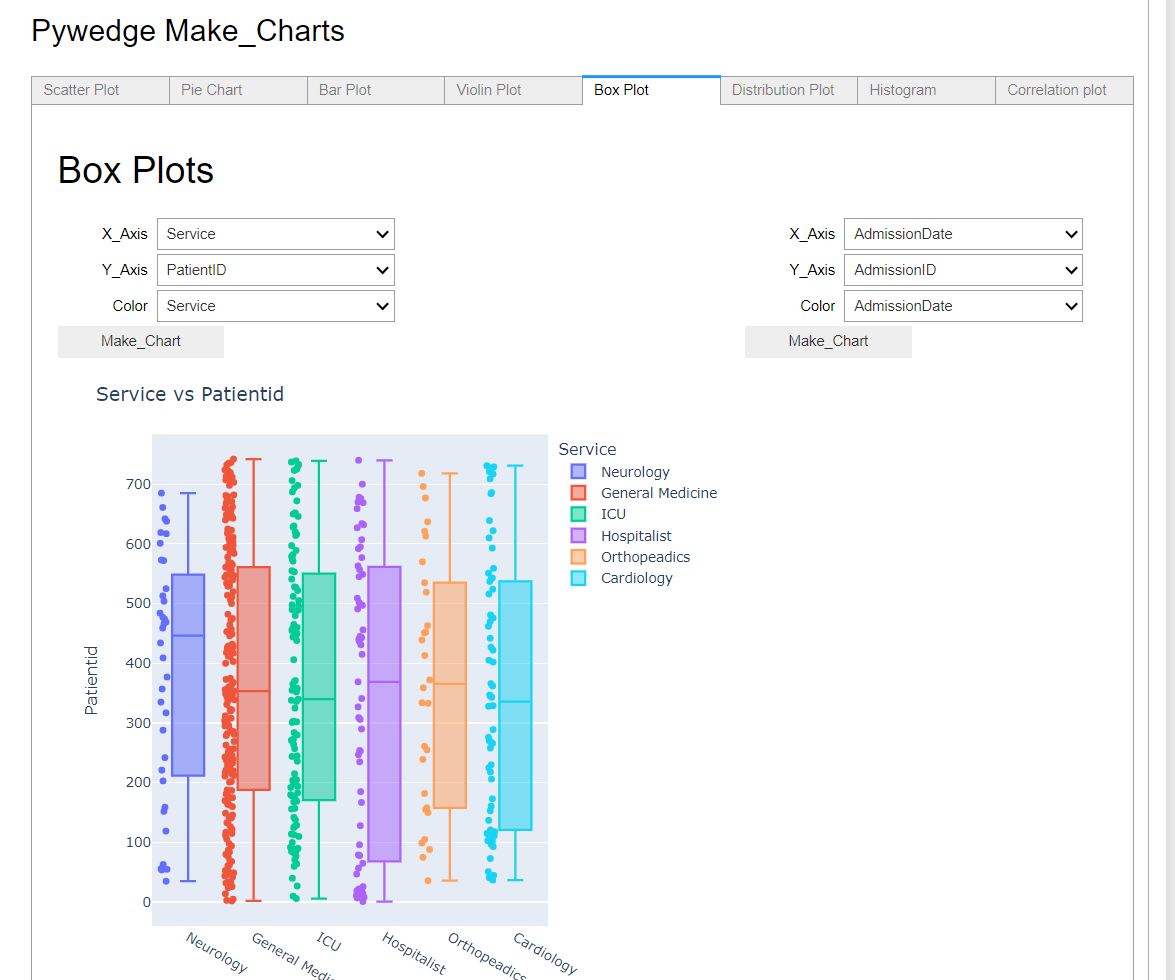

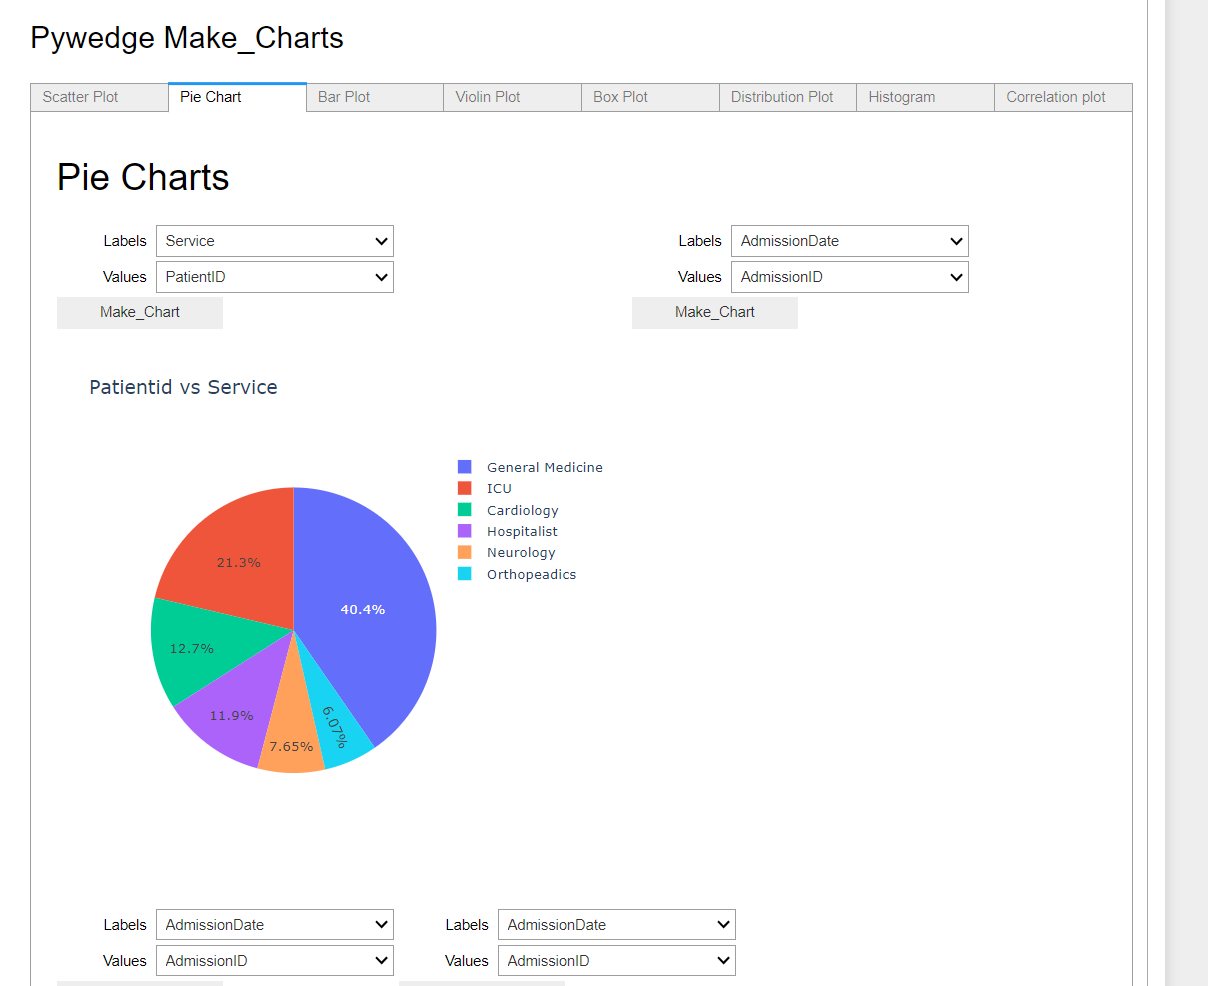

# 4. Create a 3d barplot chart by filtering Service= ["ICU", "Neurology", "General Medicine"] and find the occurence of only ExpectedLOS=[10,5,7,9] in them.


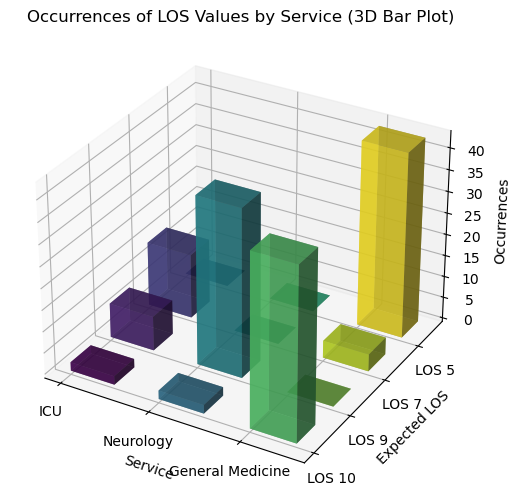

In [24]:
# rounding up LOS
re_adm['expected_los'] = np.ceil(re_adm['ExpectedLOS'])

# Filter services
filter_service = ["ICU", "Neurology", "General Medicine"]
select_service = re_adm[re_adm["Service"].isin(filter_service)]
select_LOS = [10, 9, 7, 5]

# Count occurrences of specified LOS
service_counts = {}
for service in filter_service:
    service_data = select_service[select_service["Service"] == service]
    los_sum_counts = [service_data["expected_los"].isin([los]).sum() for los in select_LOS]
    service_counts[service] = los_sum_counts

service_names = list(service_counts.keys())
occurrences = np.array(list(service_counts.values())).T

# Create a 3D bar plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

xpos, ypos = np.meshgrid(np.arange(len(service_names)), np.arange(len(select_LOS)), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = dy = 0.5
dz = occurrences.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, len(service_names) * len(select_LOS)))

for i in range(len(service_names) * len(select_LOS)):
    ax.bar3d(xpos[i], ypos[i], zpos[i], dx, dy, dz[i], shade=True, color=colors[i], alpha=0.7)

ax.set_xlabel('Service')
ax.set_ylabel('Expected LOS')
ax.set_zlabel('Occurrences')
ax.set_title('Occurrences of LOS Values by Service (3D Bar Plot)')
ax.set_xticks(np.arange(len(service_names)))
ax.set_xticklabels(service_names)
ax.set_yticks(np.arange(len(select_LOS)))
ax.set_yticklabels([f'LOS {los}' for los in select_LOS])

plt.show()



# 5.Plot ExpectedLOS based on Primary Diagnosis using radar chart

C:\Users\lalas\AppData\Local\Temp\ipykernel_45764\3086765851.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



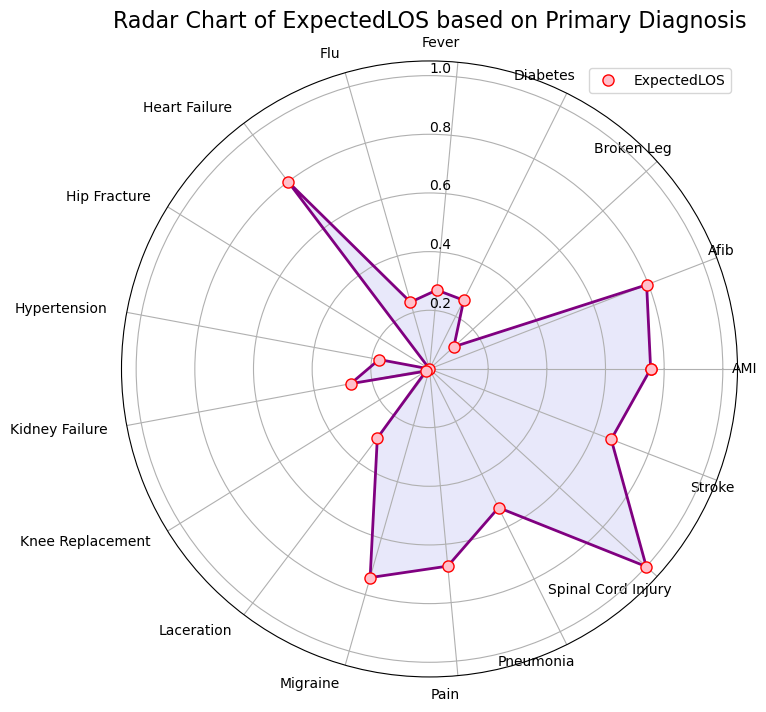

In [25]:
# Group data by Primary Diagnosis and calculate mean ExpectedLOS
diagnosis_los = re_adm.groupby('PrimaryDiagnosis')['ExpectedLOS'].mean()

diagnoses = diagnosis_los.index.tolist()

normalized_los = (diagnosis_los - diagnosis_los.min()) / (diagnosis_los.max() - diagnosis_los.min())

normalized_los = normalized_los.append(pd.Series([normalized_los.iloc[0]], index=[normalized_los.index[-1]]))

# Create angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(diagnoses) + 1)

# Plot the radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.fill(angles, normalized_los, color='lavender', alpha=0.9)
ax.plot(angles, normalized_los, color='purple', linewidth=2)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(diagnoses, ha='right')

ax.set_rlabel_position(90)
ax.set_title('Radar Chart of ExpectedLOS based on Primary Diagnosis', fontsize=16)
ax.plot(angles, normalized_los, 'o', markersize=8, color='red', markerfacecolor='pink', label='ExpectedLOS')
ax.legend(loc='upper right')

plt.show()

# 6: Add a drop down menu to your Primary Diagnosis and when selected display its averageLOS and averageMOrtality

In [26]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Cache calculated results
cached_results = {}

def calculate_metrics(service_data):
    if not service_data.empty:
        avg_los = service_data['expected_los'].mean()
        mean_mortality = service_data['ExpectedMortality'].mean()
        return avg_los, mean_mortality
    return None, None

def on_dropdown_change(change):
    with output:
        output.clear_output()
        selected_service = change.new
        
        if selected_service in cached_results:
            avg_los, mean_mortality = cached_results[selected_service]
        else:
            service_data = re_adm[re_adm['PrimaryDiagnosis'] == selected_service]
            avg_los, mean_mortality = calculate_metrics(service_data)
            cached_results[selected_service] = avg_los, mean_mortality
        
        if avg_los is not None and mean_mortality is not None:
            print(f"Selected Primary Service: {selected_service}")
            print(f"Average LOS: {avg_los:.2f}")
            print(f"Mean Expected Mortality: {mean_mortality:.2f}")
        else:
            print(f"No data available for {selected_service}")

# Create a dropdown widget with primary services
primary_services = re_adm['PrimaryDiagnosis'].unique()
service_dropdown = widgets.Dropdown(options=primary_services, description='Primary Service:')
output = widgets.Output()

service_dropdown.observe(on_dropdown_change, names='value')

display(service_dropdown, output)


Dropdown(description='Primary Service:', options=('Kidney Failure', 'Flu', 'Heart Failure', 'Pneumonia', 'AMI'…

Output()

# 7:Use sankey Chart to show the flow of patient from Primary Diagnosis to Discharge Disposition"

In [27]:
import plotly.graph_objects as go

# Calculate counts for each combination
count_data = re_adm.groupby(['PrimaryDiagnosis', 'DischargeDisposition']).count().reset_index()

# Create a Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=count_data['PrimaryDiagnosis'].unique().tolist() + count_data['DischargeDisposition'].unique().tolist(),
        color=["blue"] * len(count_data['PrimaryDiagnosis'].unique().tolist()) + ["green"] * len(count_data['DischargeDisposition'].unique().tolist())
    ),
    link=dict(
        source=count_data['PrimaryDiagnosis'].apply(lambda x: count_data['PrimaryDiagnosis'].unique().tolist().index(x)),
        target=count_data['DischargeDisposition'].apply(lambda x: len(count_data['PrimaryDiagnosis'].unique().tolist()) + count_data['DischargeDisposition'].unique().tolist().index(x)),
        value=count_data['PatientID']
    )
))

fig.update_layout(title_text="Patient Flow from Primary Diagnosis to Discharge Disposition",
                  font_size=10, width=800,height=600 )
fig.show()


# 8.Plot 3d Bubble chart to display expired patient count across race gender and age. Give a parameter to select the primary diagnosis and also gender interactive

In [28]:
merged_data = pd.merge(re_adm, pats, on='PatientID')

merged_data['DischargeDate'] = pd.to_datetime(merged_data['DischargeDate'])
merged_data['DateOfBirth'] = pd.to_datetime(merged_data['DateOfBirth'])
merged_data['age'] = (merged_data['DischargeDate'] - merged_data['DateOfBirth']).dt.days // 365

# Mapping Gender and Race
merged_data['Gender'] = merged_data['Gender'].replace({1: 'Male', 2: 'Female'})
merged_data['Race'] = merged_data['Race'].replace({1: 'White', 2: 'Black/African-American'})

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='diagnosis-dropdown',
        options=[
            {'label': diagnosis, 'value': diagnosis}
            for diagnosis in merged_data['PrimaryDiagnosis'].unique()
        ],
        value=merged_data['PrimaryDiagnosis'].unique()[0],  # Default value
        multi=False,
        placeholder="Select a Primary Diagnosis"
    ),
    dcc.Graph(id='bubble-chart')
])

# Callback to update the 3D bubble chart
@app.callback(
    dash.dependencies.Output('bubble-chart', 'figure'),
    [
        dash.dependencies.Input('diagnosis-dropdown', 'value')
    ]
)
def update_bubble_chart(selected_diagnosis):
    filtered_data = merged_data[
        (merged_data['PrimaryDiagnosis'] == selected_diagnosis) & 
        (merged_data['DischargeDisposition'] == 'Expired')  # Filter for DischargeDisposition
    ]
    fig = px.scatter_3d(
        filtered_data,
        x='PrimaryDiagnosis',
        y='age',
        z='Race',
        size='age',       
        color='Gender',
        color_discrete_map={'Male': 'blue', 'Female': 'pink'}, 
        title=f"3D Bubble Chart for Primary Diagnosis: {selected_diagnosis} (Expired Discharge)"
    )
    fig.update_traces(marker=dict(line=dict(width=2, color='white'))) 
    fig.update_layout(
        scene=dict(zaxis_title='Race'),
        width=1000,
        height=700,
        margin=dict(l=0, r=0, b=0, t=0)  # Adjust these margin values as needed
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


# 9.Plot a reverse bar graph to show patient count in each departmentID

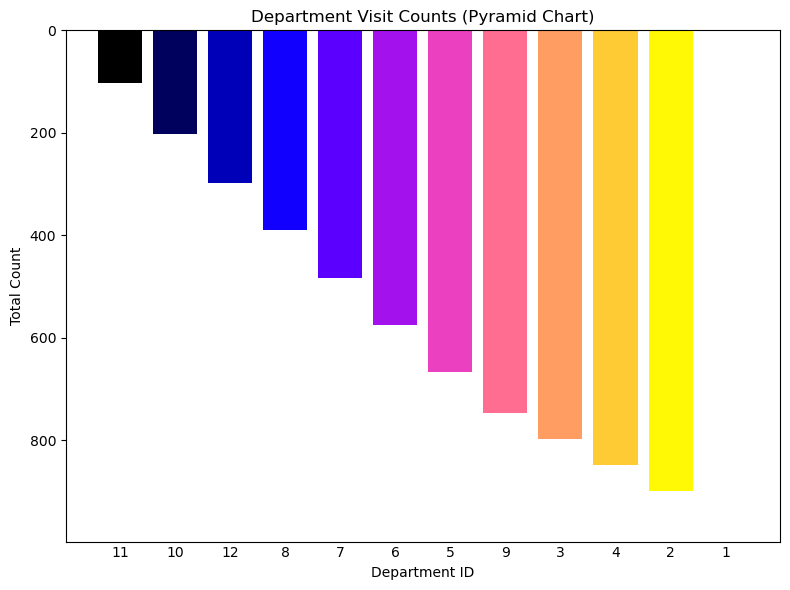

In [29]:
# Count the occurrences of each department ID
department_counts = collections.Counter(amb_visits['VisitDepartmentID'])

# Sort departments by counts
sorted_departments = sorted(department_counts.items(), key=lambda x: x[1], reverse=True)

# Extract sorted department IDs and their counts
departments, counts = zip(*sorted_departments)

# Create the pyramid chart
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(len(departments))

heights = [sum(counts[:i+1]) for i in range(len(counts))]

cmap = plt.get_cmap('gnuplot2', len(departments))

for i in range(len(departments)):
    color = cmap(i)
    ax.bar(x[i], heights[i], color=color, align='center')

# Set labels and title
ax.set_xlabel('Department ID')
ax.set_ylabel('Total Count')
ax.set_title('Department Visit Counts (Pyramid Chart)')

ax.set_xticks(x)
ax.set_xticklabels(departments)
ax.invert_yaxis()
ax.xaxis.set_tick_params(size=0)

plt.tight_layout()
plt.show()



# 10.Check for number of readmission patients and show their distribution among acuity.

In [30]:
repeated_patientids = ed_visits[ed_visits.duplicated('PatientID', keep=False)]['PatientID'].unique()

# Filter repeated patients and count readmissions by acuity
readmitted_acuity_count = {}

for patient_id in repeated_patientids:
    patient_data = ed_visits[ed_visits['PatientID'] == patient_id]
    if patient_data['EDDisposition'].nunique() > 1:
        acuity = patient_data['Acuity'].iloc[0]  # Assuming 'Acuity' is the same for readmissions
        if acuity not in readmitted_acuity_count:
            readmitted_acuity_count[acuity] = 1
        else:
            readmitted_acuity_count[acuity] += 1

print("Readmitted patients by acuity:")
for acuity, count in readmitted_acuity_count.items():
    print(f"Acuity {acuity}: {count} patients")


Readmitted patients by acuity:
Acuity 1: 7 patients
Acuity 2: 21 patients
Acuity 3: 19 patients
Acuity 4: 24 patients
Acuity 5: 44 patients


# 11: Using class function merge sheets to lookup provider name and provider speciality with the given patient ID

In [31]:
class HospitalData:
    def __init__(self, df_hosp):
        self.df_hosp = df_hosp

    def get_patient_info(self, patient_id):
        patients = self.df_hosp['Patients']
        ambulatory_visits = self.df_hosp['AmbulatoryVisits']
        providers = self.df_hosp['Providers'] 
        
        merged_data = pd.merge(patients, ambulatory_visits,
                               left_on='PatientID', right_on='PatientMRN', how='inner')
        
        merged_data = pd.merge(merged_data, providers,
                               left_on='ProviderID', right_on='ProviderID', how='left')
        
        patient_data = merged_data[merged_data['PatientID'] == patient_id]
        
        if patient_data.empty:
            print("Patient ID not found.")
        else:
            full_name = f"{patient_data['FirstName'].iloc[0]} {patient_data['LastName'].iloc[0]}"
            provider_name = patient_data['ProviderName'].iloc[0]
            provider_speciality = patient_data['ProviderSpecialty'].iloc[0]
            
            print(f"Full Name: {full_name}")
            print(f"Provider Name: {provider_name}")
            print(f"Provider Speciality: {provider_speciality}")

# Create a HospitalData object
hospital = HospitalData(df_hosp)

patient_id_input = int(input("Enter Patient ID: "))

hospital.get_patient_info(patient_id_input)


Enter Patient ID: 11
Full Name: Dean Kimberly
Provider Name: Ted Green
Provider Speciality: Pediatrics


# 12.Using iloc display full details of the longest stayed patient.

In [32]:
# Convert columns to datetime data types
ed_visits['EDDischargeTime'] = pd.to_datetime(ed_visits['EDDischargeTime'])
ed_visits['VisitDate'] = pd.to_datetime(ed_visits['VisitDate'])

ed_visits['StayDuration'] = ed_visits['EDDischargeTime'] - ed_visits['VisitDate']

index_longest_stay = ed_visits['StayDuration'].idxmax()

# Use .iloc
longest_stay_details = ed_visits.iloc[index_longest_stay]

# Extract hours, minutes, and seconds
stay_duration = longest_stay_details['StayDuration']
hours = stay_duration.seconds // 3600
minutes = (stay_duration.seconds % 3600) // 60
seconds = stay_duration.seconds % 60

print("Details of the longest stay:")
print(f"Stay Duration: {hours} hours, {minutes} minutes, {seconds} seconds")
print("Complete Details:")
print(longest_stay_details.drop('StayDuration'))

Details of the longest stay:
Stay Duration: 23 hours, 59 minutes, 43 seconds
Complete Details:
EDVisitID                                1143
PatientID                                 889
VisitDate          2020-01-14 21:28:14.588000
EDDischargeTime    2020-01-15 21:27:58.579000
Acuity                                      2
ReasonForVisit                      Pneumonia
EDDisposition                        Admitted
Name: 486, dtype: object


# 13.Which reason for visit are discharged the most.

In [33]:
# Filter EDDisposition with only "discharge"
discharged_visits = ed_visits[ed_visits['EDDisposition'] == 'Discharged']

# Group data by ReasonForVisit and calculate the count
reason_counts = discharged_visits['ReasonForVisit'].value_counts()

most_common_reason = reason_counts.idxmax()

print(f"The most common Discharged reason for Visit is: {most_common_reason}")


The most common Discharged reason for Visit is: Fever


# 14.Create a stacked bar chart for patients with age and gender using bins for age.

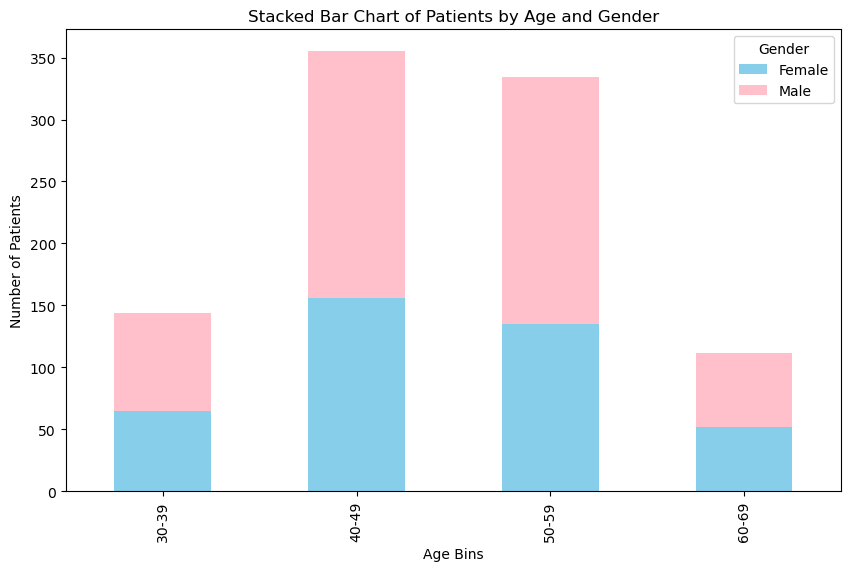

In [34]:
# Calculate age from date of birth
current_year = datetime.now().year
pats['Age'] = current_year - pd.DatetimeIndex(pats['DateOfBirth']).year

# Create age bins
age_bins = [10 * i for i in range(3, 8)]  # Create bins: 30, 40, ..., 70
pats['AgeBin'] = pd.cut(pats['Age'], bins=age_bins, labels=[f'{i}-{i+9}' for i in age_bins[:-1]])

# Group data by age bins and gender
grouped_data = pats.groupby(['AgeBin', 'Gender']).size().unstack()

# Plot a stacked bar chart
colors = ['skyblue', 'pink']
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
ax.set_xlabel('Age Bins')
ax.set_ylabel('Number of Patients')
ax.set_title('Stacked Bar Chart of Patients by Age and Gender')
ax.legend(title='Gender', loc='upper right')

plt.show()



# 15. Create a sample pptx.

In [ ]:
#pip install python-pptx

In [ ]:
# Create a new presentation
prs = Presentation()

# Slide 1: Introduction
slide1 = prs.slides.add_slide(prs.slide_layouts[0])  # Use the first slide layout
title = slide1.shapes.title
subtitle = slide1.placeholders[1]

title.text = "PY-Coders"
subtitle.text = "Team Members:\n- Amitha Konduri\n- Amitha Sridhar\n- Lavanya Kannan\n- Shishira Srinivas"

# Slide 2: Libraries Used
slide2 = prs.slides.add_slide(prs.slide_layouts[1])  
title = slide2.shapes.title
content = slide2.placeholders[1]

title.text = "Sample PPTX"
content.text = "This PPTX was created using Python"

# Slide 3: Thank You
slide3 = prs.slides.add_slide(prs.slide_layouts[5])  
title = slide3.shapes.title
content = slide3.placeholders[0]

title.text = "Thank you"
content.text = "Thank you! Have a nice day!"

# Save the presentation
prs.save("py-coders-sample.pptx")
print("Presentation saved.")


# 16:Machine Learning

In [ ]:
# 4:Machine Learning

#Merging
merged_pats_ed_visits = pd.merge(pats, ed_visits, on='PatientID', how='inner')

merged_pats_ed_ambulatory = pd.merge(merged_pats_ed_visits, amb_visits, left_on='PatientID', right_on='PatientMRN', how='inner')

final_merged_data = pd.merge(merged_pats_ed_ambulatory, re_adm, on='PatientID', how='inner')

final_merged_data

final_data = final_merged_data[['DateOfBirth', 'Gender', 'Race', 'Acuity',
                         'BloodPressureSystolic', 'BloodPressureDiastolic',
                         'Pulse', 'ExpectedMortality']]
final_data

current_year = datetime.now().year
final_data['Age'] = current_year - pd.to_datetime(final_data['DateOfBirth']).dt.year

final_data = final_data.drop(columns=['DateOfBirth'])

print(final_data.head())

# Find and count null values in final_data
null_counts = final_data.isnull().sum()

# Display the count of null values for each column
print(null_counts)

final_data.dropna(inplace=True) 

# Find and count null values in final_data
null_counts = final_data.isnull().sum()

# Display the count of null values for each column
print(null_counts)

gender_mapping = {'Male': 1, 'Female': 0}
final_data['Gender'] = final_data['Gender'].map(gender_mapping)

race_mapping = {'White': 1, 'Black/African-American': 0}
final_data['Race'] = final_data['Race'].replace(race_mapping)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_data is your DataFrame
numeric_columns = ['Age', 'Gender','Race','BloodPressureSystolic', 'BloodPressureSystolic', 'Pulse', 'ExpectedMortality']

# Create a histogram plot for numeric columns using subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(18, 4))

for i, column in enumerate(numeric_columns):
    sns.histplot(final_data[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


from sklearn.model_selection import train_test_split
final_data.dropna(inplace=True)

# Define features (X) and target variable (y)
X = final_data.drop(columns=['ExpectedMortality'])
y = final_data['ExpectedMortality']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the splits
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a list of tuples containing model names and their corresponding instances
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Support Vector Machine', SVR()),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
]

# Create an empty dictionary to store evaluation results
results = {}

# Loop through each model
for model_name, model in models:
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results in the dictionary
    results[model_name] = {
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Error': mae,
        'R-squared': r2
    }

# Print the comparison matrix
print("Comparison Matrix:")
for model_name, metrics in results.items():
    print(model_name)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

import joblib
model_filename = 'trained_random_forest_model.joblib'
joblib.dump(rf_model, model_filename)


# Load the trained model
loaded_model = joblib.load('trained_random_forest_model.joblib') 

print("Loaded Model Information:", loaded_model)

def get_user_input():
    age = int(input("Enter age: "))
    gender = int(input("Enter gender (Male: 1 / Female: 0): "))
    race = int(input("Enter race (White: 1 / Black(African/American): 2): "))
    sbp = float(input("Enter BloodPressureSystolic: "))
    dbp = float(input("Enter BloodPressureDiastolic: "))
    pulse = float(input("Enter Pulse: "))
    return {'Age': age, 'Gender': gender, 'Race': race, 
            'BloodPressureSystolic': sbp, 'BloodPressureDiastolic': dbp, 'Pulse': pulse}


def preprocess_user_input(user_input):
    # Apply the same preprocessing steps you used on your training data
    age = user_input['Age']
    gender = user_input['Gender']
    race = user_input['Race']
    sbp = user_input['BloodPressureSystolic']
    dbp = user_input['BloodPressureDiastolic']
    pulse = user_input['Pulse']
    
    # Print debug information
    print("Original Inputs:")
    print("Age:", age)
    print("Gender:", gender)
    print("Race:", race)
    print("Systolic BP:", sbp)
    print("Diastolic BP:", dbp)
    print("Pulse:", pulse)
    
    # Replace these with your actual min and max values used during scaling
    min_sbp, max_sbp = 80, 180
    min_dbp, max_dbp = 50, 120
    min_pulse, max_pulse = 60, 120
    
    # Apply scaling
    sbp_scaled = (sbp - min_sbp) / (max_sbp - min_sbp)
    dbp_scaled = (dbp - min_dbp) / (max_dbp - min_dbp)
    pulse_scaled = (pulse - min_pulse) / (max_pulse - min_pulse)
    
    preprocessed_input = {
        'Age': age, 'Gender': gender, 'Race': race,
        'BloodPressureSystolic': sbp_scaled,
        'BloodPressureDiastolic': dbp_scaled,
        'Pulse': pulse_scaled
    }
    
    # Print debug information
    print("Preprocessed Inputs:")
    print("Age:", preprocessed_input['Age'])
    print("Gender:", preprocessed_input['Gender'])
    print("Race:", preprocessed_input['Race'])
    print("Systolic BP Scaled:", preprocessed_input['BloodPressureSystolic'])
    print("Diastolic BP Scaled:", preprocessed_input['BloodPressureDiastolic'])
    print("Pulse Scaled:", preprocessed_input['Pulse'])
    
    return preprocessed_input


